###### feature set 8 chromosomes 2, 3, 4

## In this notebook:

* single input dataframe 
* using feature set 8
* random forest
* only training/test split, no epochs 
* feature importance for RF (mostly just amino acid position)

In [10]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr2-4_featureset8.pkl")



print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]


#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (13820, 15)
shape after dropping all data with score = '.' (13820, 15)
shape after dropping Unk (13820, 15)


aapos codonpos MutationTaster_score  \
chr pos     ref alt                                        
2   277003  A   G      106        2             0.588298   
    1456232 G   T      257        1                    1   
    1477383 G   T      373        1                    1   
    1477459 G   C      398        2             0.833465   
    1484596 A   T      447        1                    1   

                    fathmm-XF_coding_score     GenoCanyon_score LINSIGHT  \
chr pos     ref alt                                                        
2   277003  A   G                 0.697313      0.9777236555582        0   
    1456232 G   T                 0.122699  1.18891219212902E-5        0   
    1477383 G   T                 0.042291  0.00235440757137344        0   
    1477459 G   C                 0.493560    0.149918937837505        0   
    1484596 A   T                 0.757158   0.0853173782519132        0   

                        RVIS_ExAC     ExAC_cnv.score  \
chr pos     ref alt                                    
2   277003  A   G    -0.080196141  -1.38628707843331   
    1456232 G   T     0.064587428  -2.47162789907313   
    1477383 G   T     0.064587428  -2.47162789907313   
    1477459 G   C     0.064587428  -2.47162789907313   
    1484596 A   T     0.064587428  -2.47162789907313   

                     SORVA_LOF_MAF0.005_HetOrHom  Problematic  Mutation<1kb  \
chr pos     ref alt                                                           
2   277003  A   G                       0.000399            1             1   
    1456232 G   T                       0.004792            1             1   
    1477383 G   T                       0.004792            1             2   
    1477459 G   C                       0.004792            1             2   
    1484596 A   T                       0.004792            0             3   

                     Mutation<5kb  Mutation<10kb  Mutation<30kb  \
chr pos     ref alt                                               
2   277003  A   G               1              1              1   
    1456232 G   T               1              1              6   
    1477383 G   T               2              5             18   
    1477459 G   C               2              5             18   
    1484596 A   T               5             11             18   

                     Mutation<100kb  
chr pos     ref alt                  
2   277003  A   G                 5  
    1456232 G   T                19  
    1477383 G   T                19  
    1477459 G   C                19  
    1484596 A   T                19

In [11]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos codonpos MutationTaster_score  \
chr pos       ref alt                                        
2   222220292 G   A      341        1                    1   
4   95114733  T   C       53        1                    1   
2   178694626 C   T    10150        1                    1   

                      fathmm-XF_coding_score   GenoCanyon_score LINSIGHT  \
chr pos       ref alt                                                      
2   222220292 G   A                 0.391690  0.999999999414244        0   
4   95114733  T   C                 0.813714  0.999999997815507        0   
2   178694626 C   T                 0.545031  0.999728534038663        0   

                         RVIS_ExAC       ExAC_cnv.score  \
chr pos       ref alt                                     
2   222220292 G   A    0.126609025     1.41369465212203   
4   95114733  T   C    -0.03818213  -0.0678400328187906   
2   178694626 C   T    3.161811341                

NameError: name 'svc_disp' is not defined

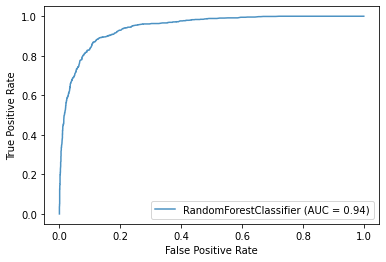

In [12]:
# Try a random forest:

from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier(random_state=1, class_weight="balanced")
forest = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced")
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
# svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()

In [ ]:
print(df_test, y_pred)